In [1]:
import sys
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import scprinter as scp
import time
import pandas as pd
import numpy as np
import pybedtools
import matplotlib.pyplot as plt
import os
import re
import math
import copy
import pyBigWig
from tqdm import tqdm
from zipfile import ZipFile
import seaborn as sns
import scipy.stats as ss

In [25]:
# Download tutorial data
wd = "/data/mhorlbec/250204_scPrinter_tutorial/CTCF_degron_tutorial"
data_url = "https://zenodo.org/records/15058588/files/CTCF_degron.tar.gz"
os.system(f"wget -P {wd} {data_url}")
zip_path = os.path.join(wd, "CTCF_degron.tar.gz")
os.system(f"tar -xzvf {zip_path} -C {wd}")
os.system(f"rm {zip_path}")
os.system("mv " + os.path.join(wd, "CTCF_degron/*") + " " + wd)
os.system("r " + os.path.join(wd, "CTCF_degron"))
os.system("rm -rf " + os.path.join(wd, "CTCF_degron"))
os.system(f"mkdir {wd}/plots")

--2025-05-12 14:09:48--  https://zenodo.org/records/15058588/files/CTCF_degron.tar.gz
188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2346162246 (2.2G) [application/octet-stream]
Saving to: ‘/data/mhorlbec/250204_scPrinter_tutorial/CTCF_degron_tutorial/CTCF_degron.tar.gz’

.......  0%  224K 2h50m...... .......... .......... ...
    50K .......... .......... .......... .......... ..........  0% 3.01M 91m23s
   100K .......... .......... .......... .......... ..........  0%  586K 82m37s
   150K .......... .......... .......... .......... ..........  0%  210M 62m1s
   200K .......... .......... .......... .......... ..........  0% 3.08M 52m2s
......... .......... .......... .......... ..........  0%  588K 54m11s
   300K .......... .......... .......... .......... ..........  0% 63.5M 46m31s
   350K .......... .......... .......... .......... ..........  0%  158M 

._CTCF_degron
CTCF_degron/
CTCF_degron/._ENCSR240PRQ.HCT-116_colon_carcinoma.CTCF.MA0139.1.damo.filt.bed
CTCF_degron/ENCSR240PRQ.HCT-116_colon_carcinoma.CTCF.MA0139.1.damo.filt.bed
CTCF_degron/._.DS_Store
CTCF_degron/.DS_Store
CTCF_degron/._CTCF_unibind_filt.bed
CTCF_degron/CTCF_unibind_filt.bed
CTCF_degron/._ENCFF575JJQ_ctcf_chip_untreated.bigWig
CTCF_degron/ENCFF575JJQ_ctcf_chip_untreated.bigWig
CTCF_degron/._ENCSR240PRQ.HCT-116_colon_carcinoma.CTCF.MA0139.1.damo.bed
CTCF_degron/ENCSR240PRQ.HCT-116_colon_carcinoma.CTCF.MA0139.1.damo.bed
CTCF_degron/._ENCFF021PQK_ctcf_chip_treated.bigWig
CTCF_degron/ENCFF021PQK_ctcf_chip_treated.bigWig


tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'


CTCF_degron/._.ipynb_checkpoints
CTCF_degron/.ipynb_checkpoints/
CTCF_degron/._all.frags.tsv.gz
CTCF_degron/all.frags.tsv.gz


tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'


CTCF_degron/._CTCF_unibind_sampled.bed
CTCF_degron/CTCF_unibind_sampled.bed


sh: r: command not found


0

### Initialize scPrinter for footprinting

In [26]:
# Sample barcodes
barcodes = ['ENCFF712GEL_ENCFF858VWC_CTCF_Un_Rep1_S1',
 'ENCFF668ATD_ENCFF582TRW_CTCF_Treated_Rep1_S1',
 'ENCFF364WVP_ENCFF680DCL_CTCF_Un_Rep2_S1',
 'ENCFF308LPR_ENCFF584DFW_CTCF_Treated_Rep2_S1']

# Initialize scPrinter object
printer = scp.pp.import_fragments(
    path_to_frags=os.path.join(wd, 'all.frags.tsv.gz'),
    barcodes=barcodes,
    savename=os.path.join(wd, 'printer_data.h5ad'),
    genome=scp.genome.hg38,
    sorted_by_barcode=True)
printer.load_disp_model()

# Create barcode grouping. This basically tells scPrinter which barcodes should be grouped in to the same sample/pseudobulk
barcode_groups = pd.DataFrame([barcodes, np.arange(4)]).T
barcode_groups.columns = ['barcode','group']
grouping, unique_groups = scp.utils.df2cell_grouping(printer, barcode_groups)
barcode_groups

single input
Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.00011896777968750006, shift detected
Minimum MSE is 0.0001048525780125, shift detected
You are now using the beta auto_detect_shift function, this overwrites the plus_shift and minus_shift you provided
If you believe the auto_detect_shift is wrong, please set auto_detect_shift=False
detected plus_shift and minus_shift are 4 -5 for /data/mhorlbec/250204_scPrinter_tutorial/CTCF_degron_tutorial/all.frags.tsv.gz


barcode group
0       ENCFF712GEL_ENCFF858VWC_CTCF_Un_Rep1_S1     0
1  ENCFF668ATD_ENCFF582TRW_CTCF_Treated_Rep1_S1     1
2       ENCFF364WVP_ENCFF680DCL_CTCF_Un_Rep2_S1     2
3  ENCFF308LPR_ENCFF584DFW_CTCF_Treated_Rep2_S1     3

### Visualize multi-scale footprints in an example region

In [51]:
chrom, center = "chr1", 225845973 # You can replace this region with any ATAC-seq peak in your dataset
start, end = center - 500, center + 500
region = f'{chrom}:{start}-{end}'

In [55]:
start = time.time()
scp.tl.get_footprint_score(
    printer,
    grouping,
    unique_groups,
    region,
    modes=np.arange(2, 101),
    footprintRadius=None,
    flankRadius=None,
    n_jobs=4,
    save_key="trial_footprints",
    backed=True,
    overwrite=True)
print ("takes", time.time()-start)

estimated file size: 0.00 GB
Creating trial_footprints in printer.footprintsadata
obs=groups, var=regions
4000 100


Submitting jobs:   0%|          | 0/99 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/99 [00:00<?, ?it/s]

takes 109.40254974365234


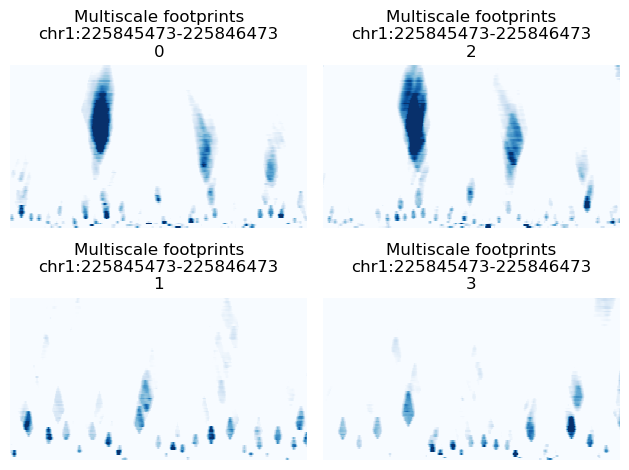

In [63]:
fig, axes = plt.subplots(2,2)
for i in range(2):
    for j in range(2):
        scp.pl.plot_footprints(printer,
                    save_key='trial_footprints',
                    group_names=unique_groups[i+j*2],
                    region=region,
                    scales=None,
                    ax=axes[i,j],
                    cmap='Blues',
                    vmin=0.75,
                    vmax=3.0)

In the above results, you can see that the two samples not treated with IAA (top left and top right) still has CTCF present in the cells, and at this locus you can see two flanking nucleosomes with a small CTCF footprint in between, at the center of the region.

In comparison, the two samples treated with IAA underwent CTCF degradation, and both the strong nucleosome footprints and CTCF footprints are lost (bottom left and bottom right). Here you see some faint diamond-shaped background noise signal. Usually when you see such diamond shapes and no strong nucleosome/TF footprints in a region, it means that the current region has very few reads and no clearly visible footprints.

Note that the lack of nucleosome footprints could mean a few things: It could be loss of nucleosome phasing, which averages out protection from Tn5 across the region, or could be the loss of accessibility (if you have no ATAC reads, you won't see footprints. This is more likely the case in this visualized example), or could be the eviction of a nucleosome exposing a DNA region.

### Calculate footprints at CTCF sites genome-wide for each sample

In [64]:
# Link: https://unibind.uio.no/static/data/20220914/macs/DAMO/ENCSR240PRQ.HCT-116_colon_carcinoma.CTCF/ENCSR240PRQ.HCT-116_colon_carcinoma.CTCF.MA0139.1.damo.bed
CTCF_bed_path = os.path.join(wd, 'ENCSR240PRQ.HCT-116_colon_carcinoma.CTCF.MA0139.1.damo.filt.bed')

# Load CTCF sites into a dataframe
CTCF_bed = pd.read_table(CTCF_bed_path, header = None)
      
# Only keep autosome and chrX, chrY
CTCF_bed = CTCF_bed[CTCF_bed[0].isin([f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"])]

In [65]:
# Load CTCF ChIP-Seq signal for treated and untreated samples
bw_chip_un = pyBigWig.open(os.path.join(wd, 'ENCFF575JJQ_ctcf_chip_untreated.bigWig'))
bw_chip_tr = pyBigWig.open(os.path.join(wd, 'ENCFF021PQK_ctcf_chip_treated.bigWig'))
chip_scores_un_matrix = []
chip_scores_tr_matrix = []
region_radius = 500
for i, row in tqdm(CTCF_bed.iterrows()):
    chr, start, end = row[:3]
    center = int((start + end) // 2)
    chip_scores_un_matrix.append(bw_chip_un.values(chr, center - region_radius, center + region_radius))
    chip_scores_tr_matrix.append(bw_chip_tr.values(chr, center - region_radius, center + region_radius))
chip_scores_un_matrix = np.array(chip_scores_un_matrix)
chip_scores_tr_matrix = np.array(chip_scores_tr_matrix)
chip_scores_un = np.mean(chip_scores_un_matrix[:, (region_radius - 10):(region_radius + 10)], axis=1)
chip_scores_tr = np.mean(chip_scores_tr_matrix[:, (region_radius - 10):(region_radius + 10)], axis=1)

48148it [00:20, 2332.76it/s]


In [66]:
# Retrieve insertion profile per chromosome
insertion_profile = copy.deepcopy(printer.fetch_insertion_profile())
for chrom in insertion_profile.keys():
    insertion_profile[chrom] = np.squeeze(np.array(np.sum(insertion_profile[chrom], axis = 0)))

# Calculate local accessibility around each variant
accessibility = []
for i, row in tqdm(CTCF_bed.iterrows()):
    chr, start, end = row[:3]
    center = int((start + end) // 2)
    accessibility.append(sum(insertion_profile[chr][(center - region_radius):(center + region_radius)]))
accessibility = np.array(accessibility)

# Filter sites by accessibility
accessibility_filter = accessibility > 200

# Keep sites with large reduction of ChIP signal after IAA treatment
degradation_filter = (chip_scores_un > np.percentile(chip_scores_un, 50)) & (chip_scores_tr < np.percentile(chip_scores_tr, 50))

# Combine the above filters
filter = accessibility_filter & degradation_filter

# Order the regions by ChIP-Seq signal in untreated
order = np.argsort(-chip_scores_un[filter])
chip_scores_un_matrix = chip_scores_un_matrix[filter, :][order, :]
chip_scores_tr_matrix = chip_scores_tr_matrix[filter, :][order, :]
chip_scores_un = chip_scores_un[filter][order]
chip_scores_tr = chip_scores_tr[filter][order]
CTCF_bed_filt = CTCF_bed.loc[filter, :].iloc[order, :]

48148it [00:12, 3796.96it/s]


In [67]:
# Save as a bed file
filt_bed_path = os.path.join(wd, "CTCF_unibind_filt.bed")
CTCF_bed_filt.to_csv(
    filt_bed_path, 
    index = False,
    sep = "\t",
    header = None)

# Calculate footrinting for the CTCF sites in each sample
region_width = 1000
start = time.time()
scp.tl.get_footprint_score(
    printer,
    grouping,
    unique_groups,
    filt_bed_path,
    region_width=region_width,
    modes=np.arange(2, 101),
    footprintRadius=None,
    flankRadius=None,
    n_jobs=16,
    save_key="degron_footprints",
    backed=True,
    overwrite=True)
adata = printer.footprintsadata['degron_footprints']
print ("takes", time.time()-start)

estimated file size: 1.69 GB
Creating degron_footprints in printer.footprintsadata
obs=groups, var=regions
4000 100


Submitting jobs:   0%|          | 0/113553 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/113553 [00:00<?, ?it/s]

takes 137.79336643218994


Visualizing footprints with radius=20bp, primarily showing CTCF footprints


1147it [00:05, 196.28it/s]
2025-05-12 15:30:47 - INFO - maxp pruned
2025-05-12 15:30:47 - INFO - cmap pruned
2025-05-12 15:30:47 - INFO - kern dropped
2025-05-12 15:30:47 - INFO - post pruned
2025-05-12 15:30:47 - INFO - FFTM dropped
2025-05-12 15:30:47 - INFO - GPOS pruned
2025-05-12 15:30:47 - INFO - GSUB pruned
2025-05-12 15:30:47 - INFO - glyf pruned
2025-05-12 15:30:47 - INFO - Added gid0 to subset
2025-05-12 15:30:47 - INFO - Added first four glyphs to subset
2025-05-12 15:30:47 - INFO - Closing glyph list over 'MATH': 13 glyphs before
2025-05-12 15:30:47 - INFO - Glyph names: ['.notdef', '.null', 'A', 'I', 'R', 'e', 'hyphen', 'nonmarkingreturn', 'one', 'p', 'plus', 'space', 'two']
2025-05-12 15:30:47 - INFO - Glyph IDs:   [0, 1, 2, 3, 14, 16, 20, 21, 36, 44, 53, 72, 83]
2025-05-12 15:30:47 - INFO - Closed glyph list over 'MATH': 13 glyphs after
2025-05-12 15:30:47 - INFO - Glyph names: ['.notdef', '.null', 'A', 'I', 'R', 'e', 'hyphen', 'nonmarkingreturn', 'one', 'p', 'plus', 'sp

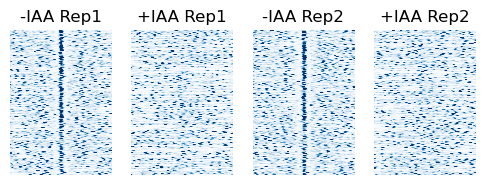

Visualizing footprints with radius=50bp, primarily showing nucleosome footprints


1147it [00:04, 249.50it/s]
2025-05-12 15:30:53 - INFO - maxp pruned
2025-05-12 15:30:53 - INFO - cmap pruned
2025-05-12 15:30:53 - INFO - kern dropped
2025-05-12 15:30:53 - INFO - post pruned
2025-05-12 15:30:53 - INFO - FFTM dropped
2025-05-12 15:30:53 - INFO - GPOS pruned
2025-05-12 15:30:53 - INFO - GSUB pruned
2025-05-12 15:30:53 - INFO - glyf pruned
2025-05-12 15:30:53 - INFO - Added gid0 to subset
2025-05-12 15:30:53 - INFO - Added first four glyphs to subset
2025-05-12 15:30:53 - INFO - Closing glyph list over 'MATH': 13 glyphs before
2025-05-12 15:30:53 - INFO - Glyph names: ['.notdef', '.null', 'A', 'I', 'R', 'e', 'hyphen', 'nonmarkingreturn', 'one', 'p', 'plus', 'space', 'two']
2025-05-12 15:30:53 - INFO - Glyph IDs:   [0, 1, 2, 3, 14, 16, 20, 21, 36, 44, 53, 72, 83]
2025-05-12 15:30:53 - INFO - Closed glyph list over 'MATH': 13 glyphs after
2025-05-12 15:30:53 - INFO - Glyph names: ['.notdef', '.null', 'A', 'I', 'R', 'e', 'hyphen', 'nonmarkingreturn', 'one', 'p', 'plus', 'sp

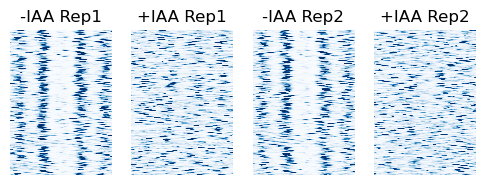

In [73]:
# Retrieve the footprint scores at a specific scale for each region in each sample
for scale in [20, 50]:
    
    if scale == 20:
        print("Visualizing footprints with radius=20bp, primarily showing CTCF footprints")
    if scale == 50:
        print("Visualizing footprints with radius=50bp, primarily showing nucleosome footprints")
        
    samples = ["-IAA Rep1", "+IAA Rep1", "-IAA Rep2", "+IAA Rep2"]
    footprint_scores = {sample:[] for sample in samples}
    ordered_regions = []
    for i, row in tqdm(CTCF_bed_filt.iterrows()):
        chr, start, end = row[:3]
        strand = row[5]
        center = int((start + end) // 2)
        region = chr + ":" + str(center - region_radius) + "-" + str(center + region_radius)
        ordered_regions.append(region)
        for sample_ind in range(len(samples)):
            fp = adata.obsm[region][sample_ind, scale - 2, :]
            if strand == "-":
                fp = np.flip(fp)
            footprint_scores[samples[sample_ind]].append(fp) # Scale - 2 because the scales are 2-100bp.
    for sample in footprint_scores.keys():
        footprint_scores[sample] = np.array(footprint_scores[sample])
    
    # Visualize as heatmaps
    edge_size = int((region_width - 800) / 2)
    fig, axes = plt.subplots(1,4, figsize=(6,2))
    vmax = 2
    for i in range(len(samples)):
        axes[i].imshow(footprint_scores[samples[i]][:, edge_size:-edge_size], interpolation="none", cmap='Blues', vmax=vmax);
        axes[i].set_title(samples[i])
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].spines[:].set_visible(False)
    plt.savefig(os.path.join(wd, "plots", "footprints_" + str(scale) + "bp_scale.pdf"))
    plt.show()

### Calculate average change of multiscale footprints after CTCF degradation

In [74]:
# Compare predicted versus observed differential footprint
samples = ["-IAA Rep1", "+IAA Rep1", "-IAA Rep2", "+IAA Rep2"]

untreated_inds = np.array([0, 2])
treated_inds = np.array([1, 3])
obs_diff = []
for region in tqdm(ordered_regions):

    # Get observed differential multi-scale footprints for the current region
    treated_footprints = np.mean(adata.obsm[region][treated_inds, :, 100:-100], axis=0)
    untreated_footprints = np.mean(adata.obsm[region][untreated_inds, :, 100:-100], axis=0)
    obs_diff.append(treated_footprints - untreated_footprints)

100%|██████████████████████████████████████████████████████████| 1147/1147 [00:02<00:00, 531.71it/s]


2025-05-12 15:32:45 - INFO - maxp pruned
2025-05-12 15:32:46 - INFO - cmap pruned
2025-05-12 15:32:46 - INFO - kern dropped
2025-05-12 15:32:46 - INFO - post pruned
2025-05-12 15:32:46 - INFO - FFTM dropped
2025-05-12 15:32:46 - INFO - GPOS pruned
2025-05-12 15:32:46 - INFO - GSUB pruned
2025-05-12 15:32:46 - INFO - glyf pruned
2025-05-12 15:32:46 - INFO - Added gid0 to subset
2025-05-12 15:32:46 - INFO - Added first four glyphs to subset
2025-05-12 15:32:46 - INFO - Closing glyph list over 'MATH': 16 glyphs before
2025-05-12 15:32:46 - INFO - Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'minus', 'nine', 'nonmarkingreturn', 'one', 'period', 'seven', 'six', 'space', 'three', 'two', 'zero']
2025-05-12 15:32:46 - INFO - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 3228]
2025-05-12 15:32:46 - INFO - Closed glyph list over 'MATH': 16 glyphs after
2025-05-12 15:32:46 - INFO - Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'minus', 'nine', 'n

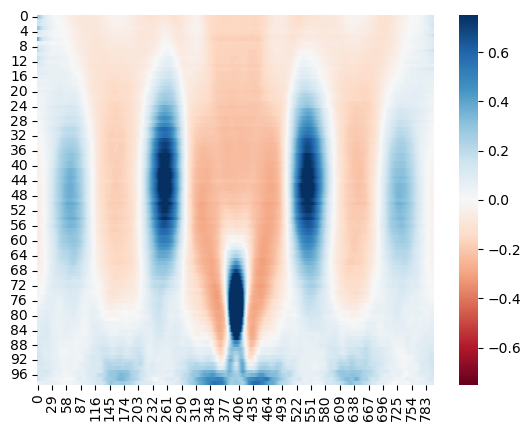

In [75]:
sns.heatmap(np.flip(-np.mean(obs_diff, axis = 0)), cmap="RdBu", vmin = -0.75, vmax = 0.75)
plt.savefig(os.path.join(wd, "plots", "aggregate_obs_diff.pdf"))
plt.show()